In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-ancient-texts-provenance-challenge/sample_submission.csv
/kaggle/input/the-ancient-texts-provenance-challenge/train.csv
/kaggle/input/the-ancient-texts-provenance-challenge/test.csv


# Step 1: Setup and Environment


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# !pip install -q "pyarrow<20.0.0" "pydantic<2.12" "google-cloud-bigquery>=3.31.0" "rich<14" --upgrade
# !pip install -q datasets 
# !pip install -q transformers
# !pip install -q accelerate
# !pip install -q scikit-learn

In [7]:
!pip install -U transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 93.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 1.0.0rc2
    Uninstalling huggingface-hub-1.0.0rc2:
      Successfully uninstalled huggingface-hub-1.0.0rc2
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.3
    Uninstalling transformers-4.53.3:
      Successfully uninstalled transformers-4.53.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

### Restart the environment before proceding (click on "Restart & Clear Cell Outputs")

In [8]:
import os
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import torch

os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)

2025-10-20 06:10:15.242877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760940615.435331      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760940615.497213      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 2: Configuration

In [9]:
class CFG:
    # Baseline model name 
    model_name = "xlm-roberta-base"
    
    # Competition data paths    
    train_path = "/kaggle/input/the-ancient-texts-provenance-challenge/train.csv"
    test_path = "/kaggle/input/the-ancient-texts-provenance-challenge/test.csv"
    submission_path = "/kaggle/input/the-ancient-texts-provenance-challenge/sample_submission.csv"
    
    # Training hyperparameters
    max_length = 256        # Maximum sequence length for the tokenizer
    batch_size = 16         # Batch size for training and evaluation
    learning_rate = 2e-5    # Learning rate for the AdamW optimizer
    weight_decay = 0.01     # Weight decay for regularization
    num_epochs = 3          # Number of training epochs
    seed = 42               # Random seed
    val_size = 0.2         # Fraction of training data to use for validation
    test_size = 0.1         # Fraction of training data to use for testing


# Step 3: Data Loading and Preprocessing

In [10]:
print("Loading data...")
train_df = pd.read_csv(CFG.train_path)
test_df = pd.read_csv(CFG.test_path)
submission_df = pd.read_csv(CFG.submission_path)
test_df['__index_level_0__'] = np.nan

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")


Loading data...
Training data shape: (119656, 3)
Test data shape: (29914, 3)


In [11]:
# Create label mappings
unique_labels = sorted(train_df['label'].unique())
label2id = {int(label): i for i, label in enumerate(unique_labels)}
id2label = {i: int(label) for i, label in enumerate(unique_labels)}
num_labels = len(unique_labels)

# Apply the mapping to the training dataframe
train_df['label'] = train_df['label'].map(label2id)

print(f"\nNumber of unique labels: {num_labels}")
print("Label to ID mapping:", label2id)



Number of unique labels: 15
Label to ID mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14}


##  Step 3.1: Data Exploration

In [12]:
def normalization_factors(train_df, smoothing_factor):
    temp_df_for_plotting = train_df.copy()
    temp_df_for_plotting['label_str'] = temp_df_for_plotting['label'].map({v: k for k, v in label2id.items()})

    class_percentages = temp_df_for_plotting['label_str'].value_counts(normalize=True)
    
    if not (0.0 <= smoothing_factor <= 1.0):
        raise ValueError("smoothing_factor must be between 0.0 and 1.0")
    
    smoothed_proportions = class_percentages ** smoothing_factor
    new_proportions = smoothed_proportions / smoothed_proportions.sum()


    comparison_df = pd.DataFrame({
        'Old %': class_percentages * 100,
        'New %': new_proportions * 100
    })

    comparison_df['Actual Change'] = comparison_df['New %'] - comparison_df['Old %']
    comparison_df['Percentage Change'] = (comparison_df['Actual Change'] / comparison_df['Old %']) * 100
    
    comparison_df['Old %'] = comparison_df['Old %'].map('{:.4f}%'.format)
    comparison_df['New %'] = comparison_df['New %'].map('{:.2f}%'.format)
    comparison_df['Actual Change'] = comparison_df['Actual Change'].map('{:+.2f}%'.format) # Add sign for clarity
    comparison_df['Percentage Change'] = comparison_df['Percentage Change'].map('{:+.2f}%'.format)

    print("Resampling Proportions Analysis:")
    display(comparison_df)
    
    return new_proportions

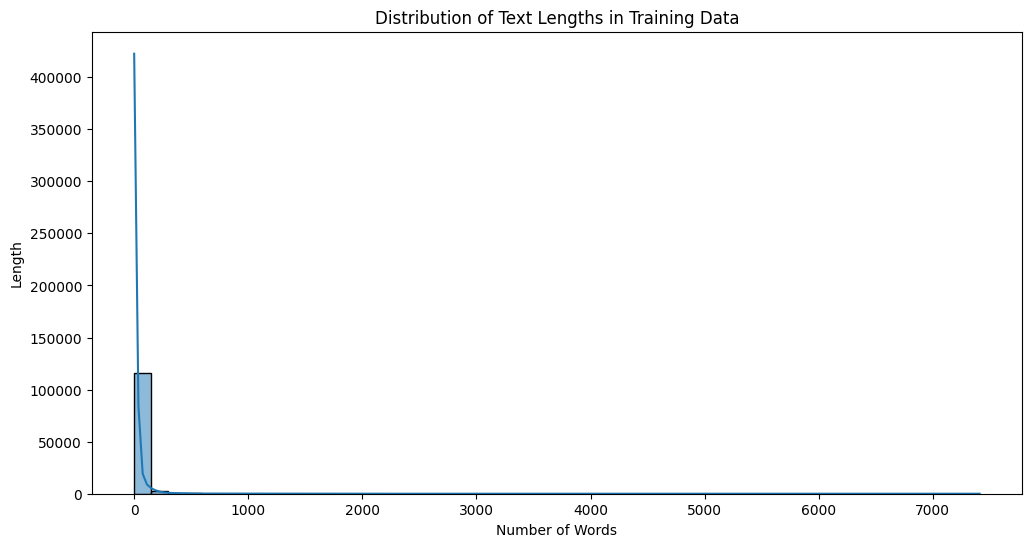

Class Distribution Summary:


,Count,Percentage
label_str,,
7,35283,29.4870%
8,18901,15.7961%
5,16871,14.0996%
0,9104,7.6085%
6,7297,6.0983%
3,5942,4.9659%
1,5839,4.8798%
10,5643,4.7160%
4,5184,4.3324%


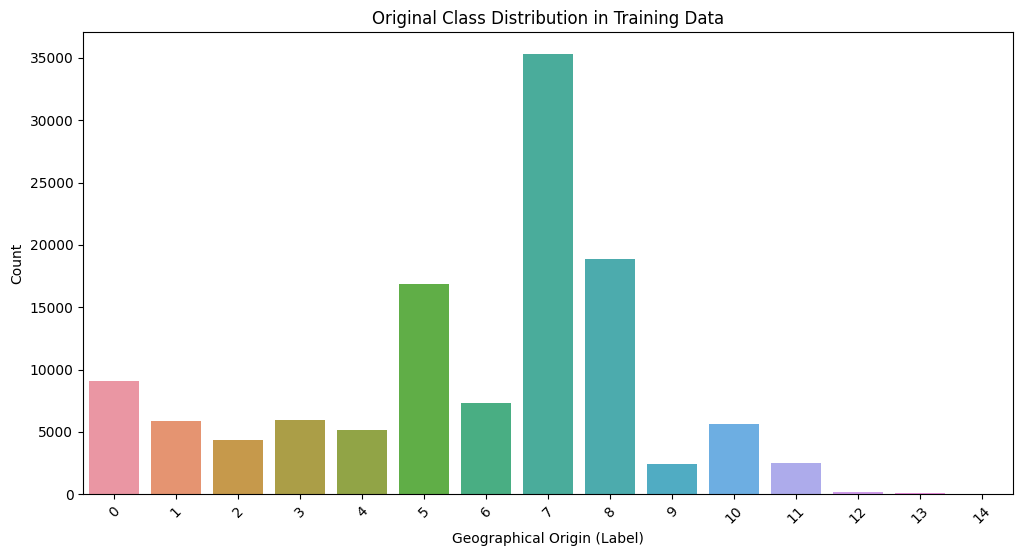

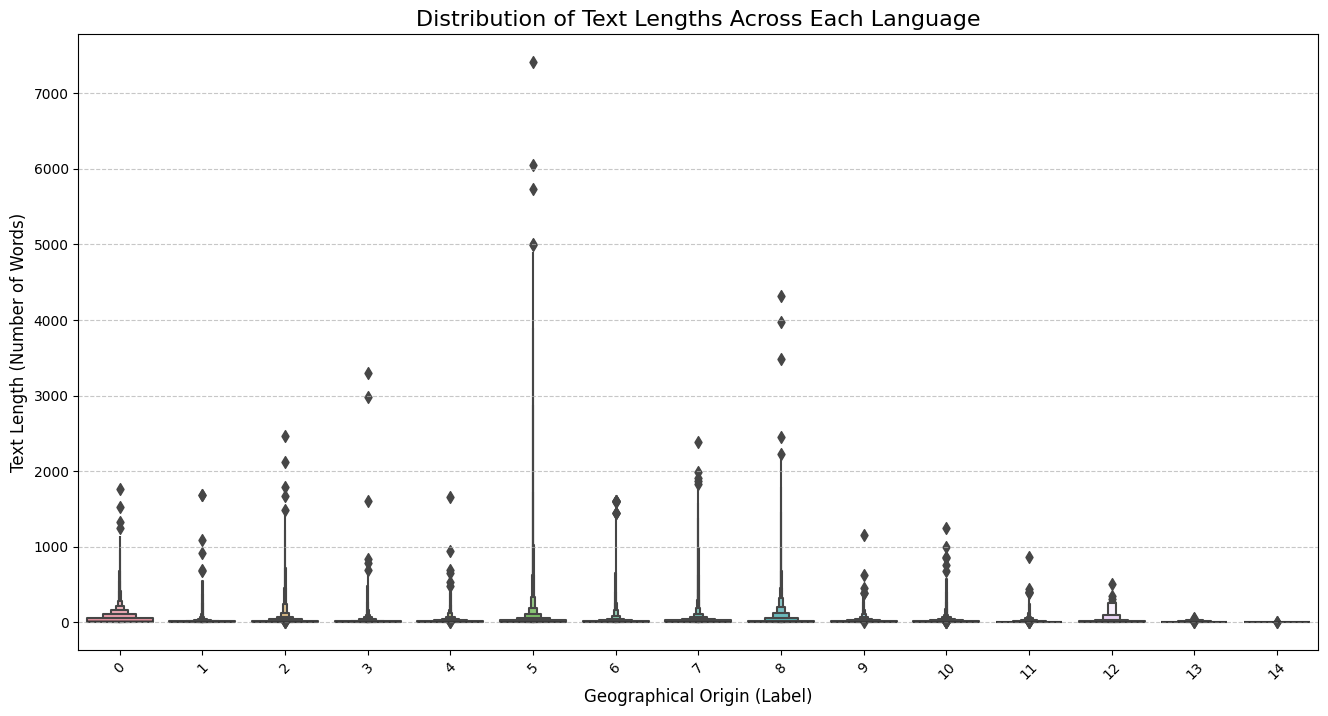

In [13]:
def data_plots(train_df):
    train_df_c = train_df.copy()
    
    # Visualize Text Length Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(train_df_c['text_length'], bins=50, kde=True)
    plt.title('Distribution of Text Lengths in Training Data')
    plt.xlabel('Number of Words')
    plt.ylabel('Length')
    plt.show()
    
    # Class distribution
    temp_df_for_plotting = train_df_c.copy()
    temp_df_for_plotting['label_str'] = temp_df_for_plotting['label'].map({v: k for k, v in label2id.items()})
    class_counts = temp_df_for_plotting['label_str'].value_counts()
    class_percentages = temp_df_for_plotting['label_str'].value_counts(normalize=True)
    summary_df = pd.DataFrame({
        'Count': class_counts,
        'Percentage': class_percentages * 100
    })
    summary_df['Percentage'] = summary_df['Percentage'].map('{:.4f}%'.format)
    print("Class Distribution Summary:")
    display(summary_df)

    plt.figure(figsize=(12, 6))
    sns.countplot(x='label_str', data=temp_df_for_plotting, order=sorted(unique_labels))
    plt.title('Original Class Distribution in Training Data')
    plt.xlabel('Geographical Origin (Label)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
    # Visualize Text Length Distribution
    plt.figure(figsize=(16, 8))
    sns.boxenplot(
        x='label_str',
        y='text_length',
        data=temp_df_for_plotting,
        order=unique_labels  # Ensures the x-axis is sorted alphabetically
    )
    
    plt.title('Distribution of Text Lengths Across Each Language', fontsize=16)
    plt.xlabel('Geographical Origin (Label)', fontsize=12)
    plt.ylabel('Text Length (Number of Words)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
data_plots(train_df)


##  Step 3.2: Data Filtering

Original number of samples: 119656
Number of samples after filtering by length (1-1200 words): 119532
Percentage reduction in samples: 99.90%


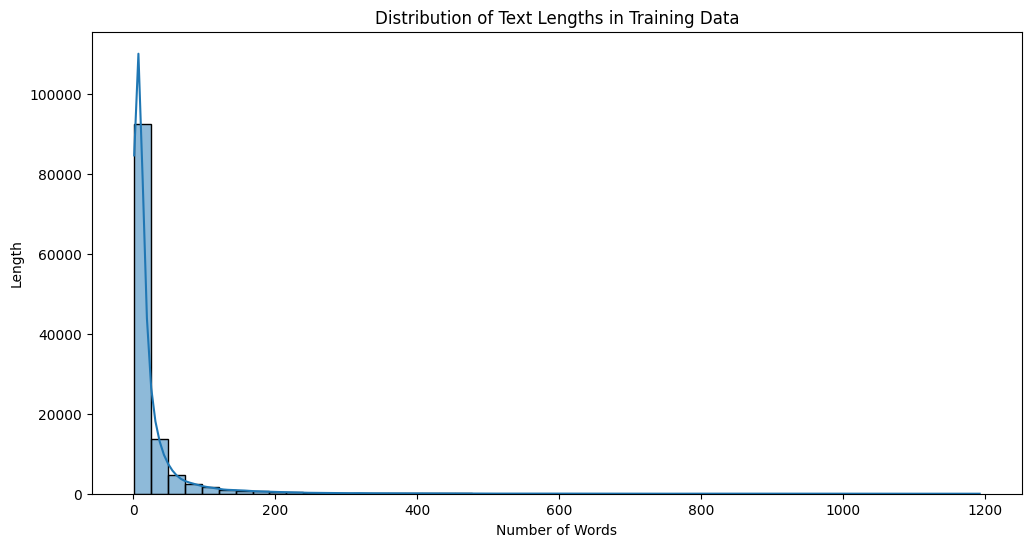

Class Distribution Summary:


,Count,Percentage
label_str,,
7,35261,29.4992%
8,18877,15.7924%
5,16822,14.0732%
0,9100,7.6130%
6,7289,6.0979%
3,5939,4.9685%
1,5837,4.8832%
10,5642,4.7201%
4,5183,4.3361%


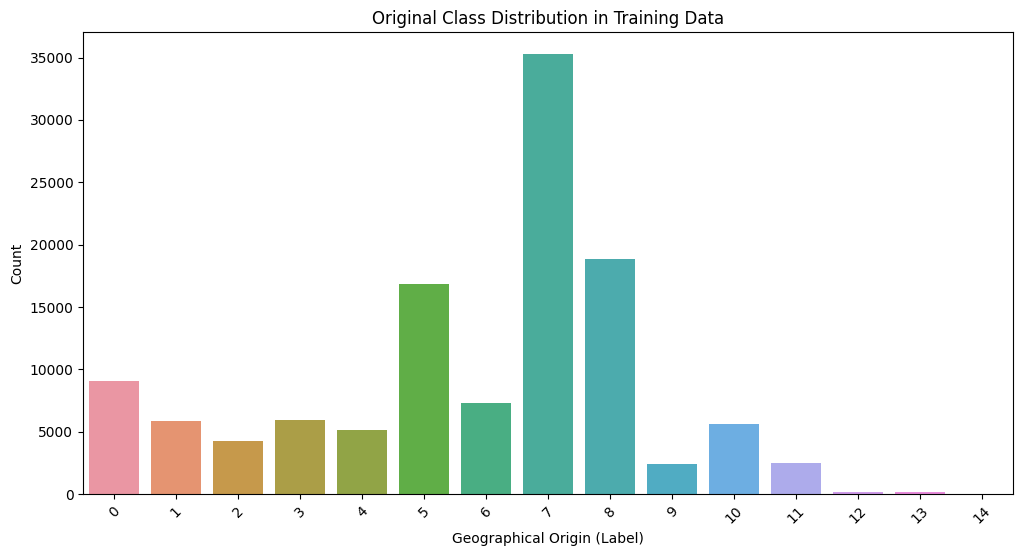

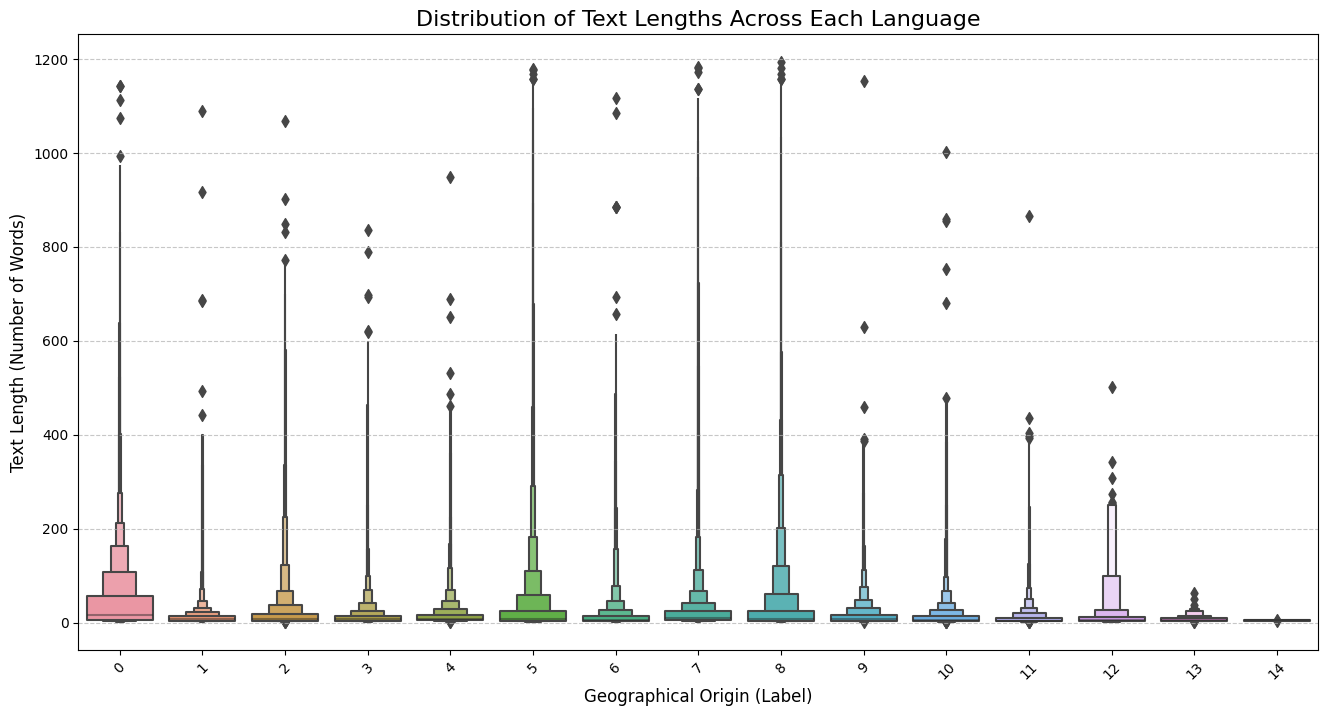

In [14]:
# filtering by range
MIN_LEN = 1
MAX_LEN = 1200
original_samples = len(train_df)
print(f"Original number of samples: {original_samples}")
train_df = train_df[(train_df['text_length'] >= MIN_LEN) & (train_df['text_length'] <= MAX_LEN)]
word_limit_samples = len(train_df)
print(f"Number of samples after filtering by length ({MIN_LEN}-{MAX_LEN} words): {word_limit_samples}")
print(f"Percentage reduction in samples: {(word_limit_samples/original_samples)*100:.2f}%")
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
data_plots(train_df)

In [15]:
normalization_factors(train_df, 0.9)

Resampling Proportions Analysis:


,Old %,New %,Actual Change,Percentage Change
label_str,,,,
7,29.4992%,26.74%,-2.76%,-9.37%
8,15.7924%,15.24%,-0.56%,-3.52%
5,14.0732%,13.73%,-0.34%,-2.41%
0,7.6130%,7.90%,+0.29%,+3.78%
6,6.0979%,6.47%,+0.37%,+6.11%
3,4.9685%,5.38%,+0.41%,+8.30%
1,4.8832%,5.30%,+0.41%,+8.49%
10,4.7201%,5.14%,+0.42%,+8.86%
4,4.3361%,4.76%,+0.42%,+9.79%


label_str
7     0.267357
8     0.152358
5     0.137346
0     0.079007
6     0.064703
3     0.053811
1     0.052978
10    0.051383
4     0.047605
2     0.040281
11    0.025036
9     0.024040
12    0.002186
13    0.001869
14    0.000040
Name: proportion, dtype: float64

Resampling Proportions Analysis:


,Old %,New %,Actual Change,Percentage Change
label_str,,,,
7,29.4992%,26.74%,-2.76%,-9.37%
8,15.7924%,15.24%,-0.56%,-3.52%
5,14.0732%,13.73%,-0.34%,-2.41%
0,7.6130%,7.90%,+0.29%,+3.78%
6,6.0979%,6.47%,+0.37%,+6.11%
3,4.9685%,5.38%,+0.41%,+8.30%
1,4.8832%,5.30%,+0.41%,+8.49%
10,4.7201%,5.14%,+0.42%,+8.86%
4,4.3361%,4.76%,+0.42%,+9.79%



Total samples after resampling: 119524


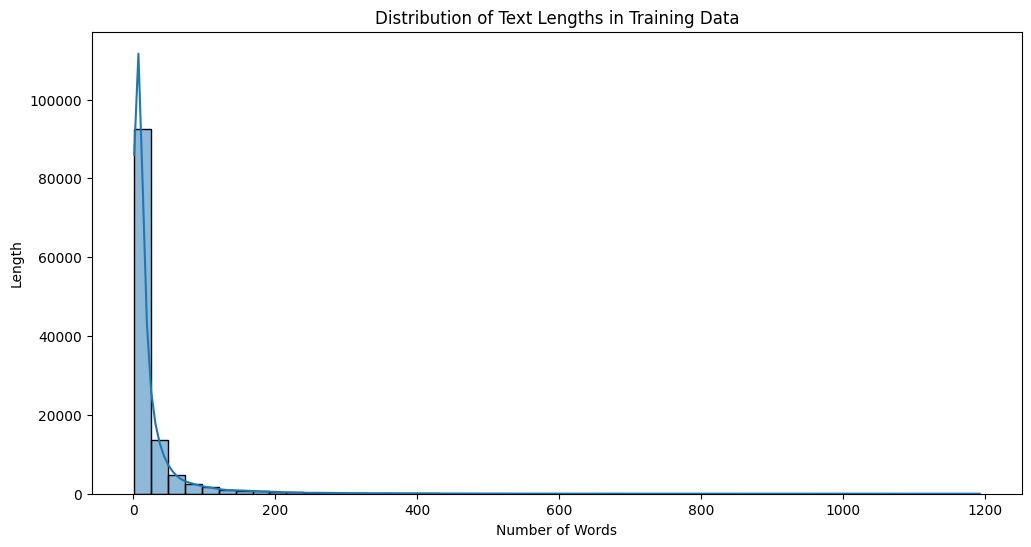

Class Distribution Summary:


,Count,Percentage
label_str,,
7,31957,26.7369%
8,18211,15.2363%
5,16417,13.7353%
0,9443,7.9005%
6,7734,6.4707%
3,6432,5.3813%
1,6332,5.2977%
10,6141,5.1379%
4,5690,4.7606%


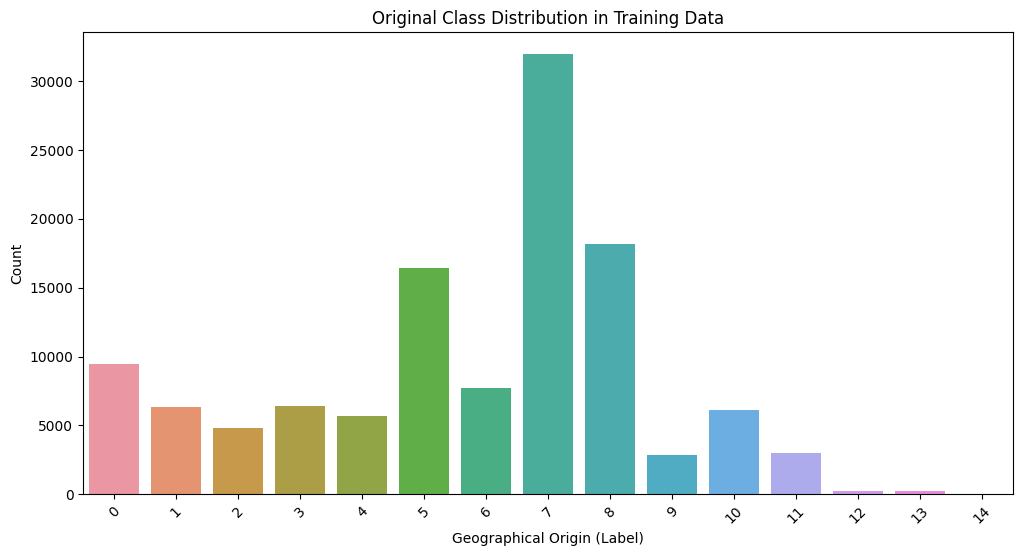

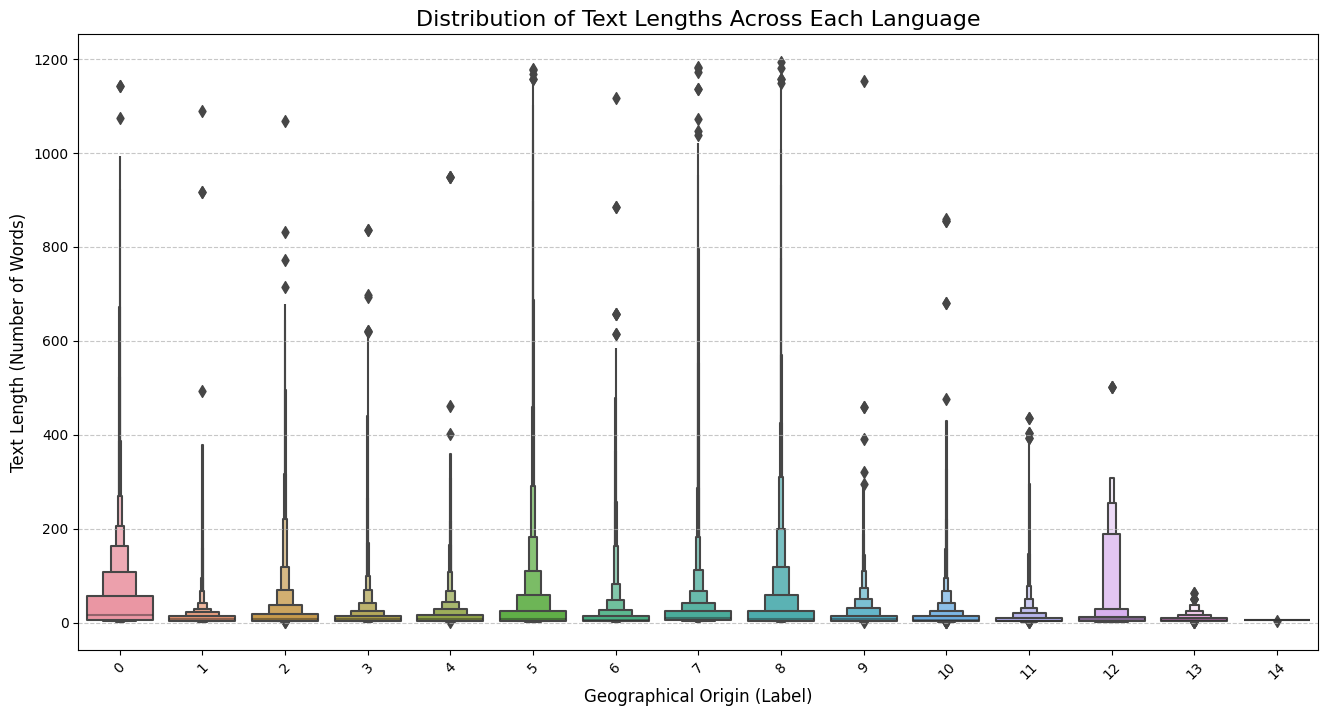

In [16]:
# Distribution normalization
desired_distribution = normalization_factors(train_df, 0.9)
desired_distribution = desired_distribution.to_dict()

assert abs(sum(desired_distribution.values()) - 1.0) < 1e-6, "Percentages must sum to 1.0"

resampled_dfs = []
total_samples = len(train_df) # Or you can set a fixed number like 100000

for label, percentage in desired_distribution.items():
    n_samples = int(total_samples * percentage)
    class_df = train_df[train_df['label'] == label]
    # We sample with replacement if we need more samples than available
    replace = n_samples > len(class_df)
    resampled_dfs.append(class_df.sample(n=n_samples, random_state=CFG.seed, replace=replace))

# Combine the resampled dataframes and shuffle
train_df = pd.concat(resampled_dfs).sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
print(f"\nTotal samples after resampling: {len(train_df)}")

train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
data_plots(train_df)


##  Step 3.3: Data Segregation

In [17]:
# Split the data into training and validation sets

# #################################################################################################
# # to be removed later before submition
# train_df, _ = train_test_split(
#     train_df,
#     test_size=0.5,
#     random_state=CFG.seed,
#     stratify=train_df['label']  # Stratify to maintain label distribution
# )
# test_df, _ = train_test_split(
#     test_df,
#     test_size=0.9,
#     random_state=CFG.seed,
# )
# #################################################################################################

train_val_df, test_model_df = train_test_split(
    train_df,
    test_size=CFG.test_size,
    random_state=CFG.seed,
    stratify=train_df['label']
)


train_sub_df, val_df = train_test_split(
    train_val_df,
    test_size=CFG.val_size, # This uses the 0.1 from your CFG class on the remaining data
    random_state=CFG.seed,
    stratify=train_val_df['label']
)

print(f"\nTraining subset shape: {train_sub_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Final model test set shape: {test_model_df.shape}")



Training subset shape: (86056, 4)
Validation set shape: (21515, 4)
Final model test set shape: (11953, 4)


In [18]:

# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_sub_df)
val_dataset = Dataset.from_pandas(val_df)
evaluation_test_dataset = Dataset.from_pandas(test_model_df) # Our held-out test set
competition_test_dataset = Dataset.from_pandas(test_df) # The competition's blind test set


ds = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'evaluation_test': evaluation_test_dataset, # For our own evaluation
    'competition_test': competition_test_dataset # For final submission
})

print("\nDataset structure:")
print(ds)



Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'text_length', '__index_level_0__'],
        num_rows: 86056
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'text_length', '__index_level_0__'],
        num_rows: 21515
    })
    evaluation_test: Dataset({
        features: ['id', 'text', 'label', 'text_length', '__index_level_0__'],
        num_rows: 11953
    })
    competition_test: Dataset({
        features: ['id', 'text', '__index_level_0__'],
        num_rows: 29914
    })
})


# Step 4: Tokenization

In [19]:

print(f"\nLoading tokenizer for model: {CFG.model_name}")
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

def tokenize_function(examples):
    """Tokenizes the text data in a batch."""
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=False,  # The DataCollator will handle padding
        max_length=CFG.max_length
    )

print("Tokenizing datasets...")
tokenized_ds = ds.map(tokenize_function, batched=True)

# Remove unnecessary columns to clean up the dataset
tokenized_ds = tokenized_ds.remove_columns(['id', 'text', '__index_level_0__'])
print("\nTokenized dataset structure:")
print(tokenized_ds)



Loading tokenizer for model: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/86056 [00:00<?, ? examples/s]

Map:   0%|          | 0/21515 [00:00<?, ? examples/s]

Map:   0%|          | 0/11953 [00:00<?, ? examples/s]

Map:   0%|          | 0/29914 [00:00<?, ? examples/s]


Tokenized dataset structure:
DatasetDict({
    train: Dataset({
        features: ['label', 'text_length', 'input_ids', 'attention_mask'],
        num_rows: 86056
    })
    validation: Dataset({
        features: ['label', 'text_length', 'input_ids', 'attention_mask'],
        num_rows: 21515
    })
    evaluation_test: Dataset({
        features: ['label', 'text_length', 'input_ids', 'attention_mask'],
        num_rows: 11953
    })
    competition_test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 29914
    })
})


# Step 5: Model

##  Step 5.1: Class weighted loss normalization

In [20]:
def plot_class_weights(class_weights):
    import matplotlib.pyplot as plt
    import numpy as np
    
    class_labels = [f'Class {i}' for i in range(len(class_weights))]
    plt.figure(figsize=(12, 7))  # Adjust figure size for better readability
    bars = plt.bar(class_labels, class_weights, color='skyblue')
    
    # 4. Add labels and title for clarity
    plt.xlabel('Class Label', fontsize=12)
    plt.ylabel('Computed Class Weight', fontsize=12)
    plt.title('Class Weights for Loss Function', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels to prevent overlap
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for easier value reading
    
    # Optional: Add the weight value on top of each bar for precise reading
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center') # va='bottom' puts text above the bar
    
    # 5. Display the plot
    plt.tight_layout() # Adjust layout to make sure everything fits
    plt.show()

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import torch

# Ensure the device is set correctly (for GPU training in Kaggle)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Calculating class weights for handling imbalance...")

# Get the class labels from the training subset
train_labels = train_sub_df['label'].values

# Calculate weights using scikit-learn's utility function
# 'balanced' mode automatically computes weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert weights to a PyTorch tensor and move it to the correct device (GPU)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Computed class weights: {class_weights_tensor.cpu().numpy()}")
print()
print("Computed class weights:", [f"{w:.4f}" for w in class_weights_tensor.cpu().numpy()])

Calculating class weights for handling imbalance...
Computed class weights: [8.4381038e-01 1.2584046e+00 1.6552414e+00 1.2388397e+00 1.4003092e+00
 4.8536944e-01 1.0303640e+00 2.4934012e-01 4.3754321e-01 2.7728693e+00
 1.2976853e+00 2.6634479e+00 3.0516312e+01 3.5633953e+01 2.8685334e+03]

Computed class weights: ['0.8438', '1.2584', '1.6552', '1.2388', '1.4003', '0.4854', '1.0304', '0.2493', '0.4375', '2.7729', '1.2977', '2.6634', '30.5163', '35.6340', '2868.5334']


In [22]:
class_weights_tensor = torch.log1p(class_weights_tensor)
class_weights = class_weights_tensor.cpu().numpy()
print("Computed class weights:", [f"{w:.4f}" for w in class_weights])

class_weights_tensor = torch.log1p(class_weights_tensor)
class_weights = class_weights_tensor.cpu().numpy()
print("Computed class weights:", [f"{w:.4f}" for w in class_weights])

Computed class weights: ['0.6118', '0.8147', '0.9765', '0.8060', '0.8756', '0.3957', '0.7082', '0.2226', '0.3629', '1.3278', '0.8319', '1.2984', '3.4505', '3.6010', '7.9619']
Computed class weights: ['0.4774', '0.5959', '0.6813', '0.5911', '0.6289', '0.3334', '0.5354', '0.2010', '0.3096', '0.8449', '0.6054', '0.8322', '1.4930', '1.5263', '2.1930']


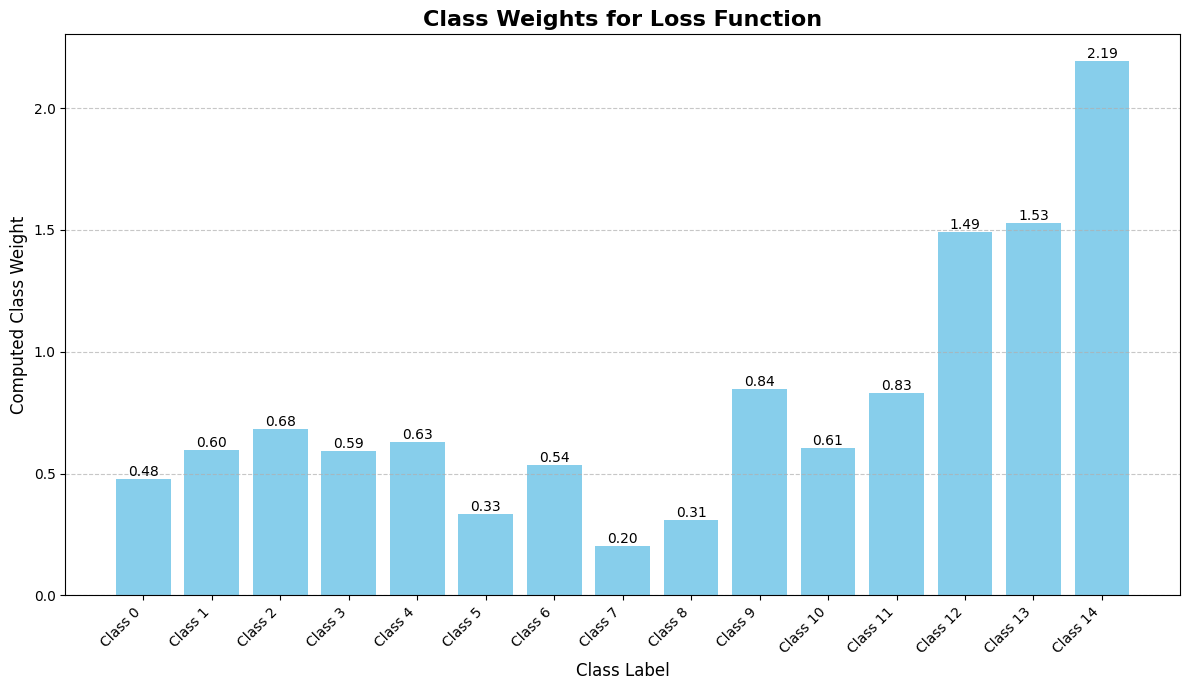

In [23]:
plot_class_weights(class_weights)

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# 2. Define your desired new range
target_min = 1.0
target_max = 1.5  # 50% more than the minimum

# 3. Get the min and max of your current weights
current_min = torch.min(class_weights_tensor)
current_max = torch.max(class_weights_tensor)

# 4. Apply the Min-Max scaling formula
# Formula: new_val = (val - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
scaled_weights_tensor = (class_weights_tensor - current_min) / (current_max - current_min) * (target_max - target_min) + target_min
scaled_weights = scaled_weights_tensor.cpu().numpy()

# --- VERIFY THE RESULTS ---
print("SCALED weights:", [f"{w:.4f}" for w in scaled_weights_tensor.cpu().numpy()])
print(f"\nVerification:")
print(f"New Minimum Weight: {torch.min(scaled_weights_tensor):.4f} (Should be {target_min})")
print(f"New Maximum Weight: {torch.max(scaled_weights_tensor):.4f} (Should be {target_max})")

# This 'scaled_weights_tensor' is what you should pass to your loss function
# e.g., loss_fn = nn.CrossEntropyLoss(weight=scaled_weights_tensor.to(device))

SCALED weights: ['1.0694', '1.0991', '1.1206', '1.0979', '1.1074', '1.0332', '1.0840', '1.0000', '1.0273', '1.1616', '1.1015', '1.1584', '1.3243', '1.3327', '1.5000']

Verification:
New Minimum Weight: 1.0000 (Should be 1.0)
New Maximum Weight: 1.5000 (Should be 1.5)


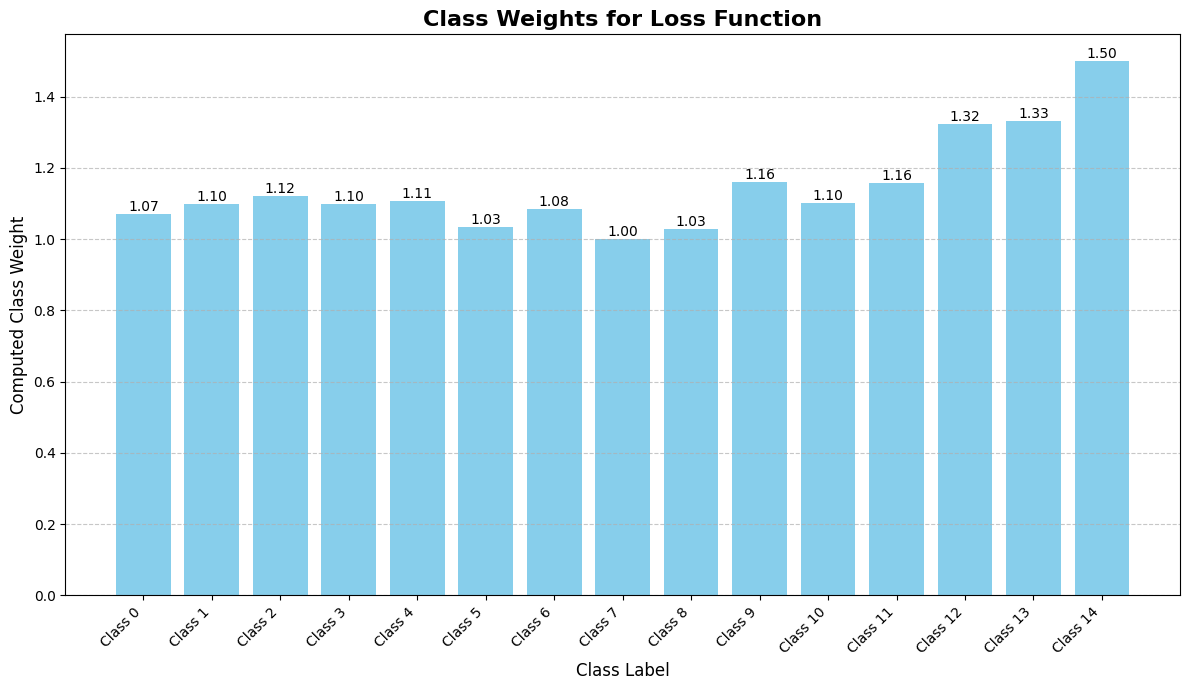

In [25]:
plot_class_weights(scaled_weights)

In [26]:
mean_weight = scaled_weights.mean()
scaled_weights = scaled_weights + (mean_weight - scaled_weights) * 0.7

scaled_weights_tensor = torch.tensor(scaled_weights, dtype=torch.float).to(device)

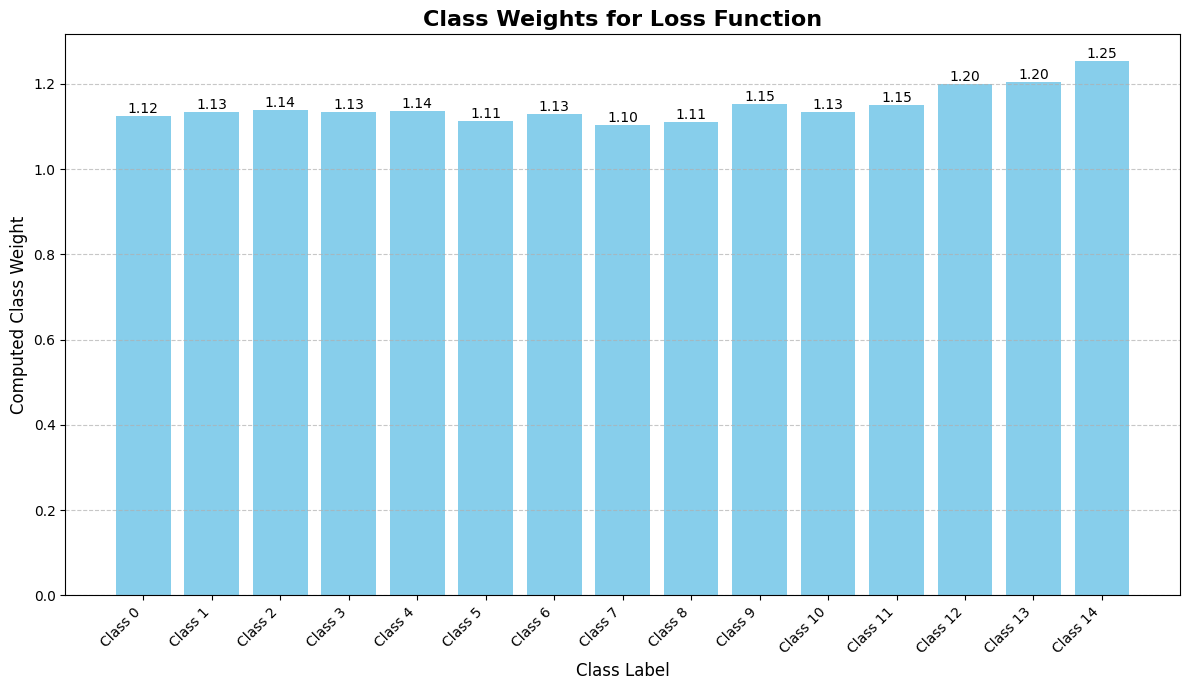

In [27]:
plot_class_weights(scaled_weights)

##  Step 5.2: Configuration

In [28]:
class WeightedLossTrainer(Trainer):
    """
    A custom Trainer that uses a weighted CrossEntropyLoss to handle class imbalance.
    """
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=scaled_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

In [29]:
def compute_metrics(eval_pred):
    """Computes Macro F1-score for evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Calculate Macro F1 score
    f1 = f1_score(labels, predictions, average="macro")
    
    return {"f1": f1}


In [30]:
print(f"\nLoading model: {CFG.model_name}")
model = AutoModelForSequenceClassification.from_pretrained(
    CFG.model_name,
    num_labels=int(num_labels),
    id2label=id2label,
    label2id=label2id
)


Loading model: xlm-roberta-base


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
import math
def calculate_steps_per_epoch(total_train_samples: int, per_device_batch_size: int, num_epochs: int) -> int:
    """
    Calculates the number of training steps per epoch.

    Args:
        total_train_samples (int): The total number of samples in the training dataset.
        per_device_batch_size (int): The batch size used on each individual device (GPU/CPU).

    Returns:
        int: The total number of steps in one epoch.
    """
    # 1. Determine the number of GPUs available, defaulting to 1 (for CPU training)
    num_gpus = torch.cuda.device_count()
    if num_gpus == 0:
        num_gpus = 1
        print("No GPU detected. Running on CPU. Number of devices is 1.")
    else:
        print(f"Detected {num_gpus} GPUs.")

    # 2. Calculate the total global batch size
    total_batch_size = per_device_batch_size * num_gpus
    print(f"Global batch size is: {total_batch_size} ({per_device_batch_size} per device x {num_gpus} devices)")

    # 3. Calculate steps and round up to account for the last partial batch
    steps_per_epoch = math.ceil((total_train_samples / total_batch_size))
    
    return steps_per_epoch

steps_per_epoch = calculate_steps_per_epoch(
    total_train_samples=len(train_dataset),
    per_device_batch_size=CFG.batch_size,
    num_epochs = CFG.num_epochs
)

print(steps_per_epoch)

Detected 1 GPUs.
Global batch size is: 16 (16 per device x 1 devices)
5379


In [32]:
# with eval strategy as epoch
# training_args = TrainingArguments(
#     output_dir="./results",

#     per_device_train_batch_size=CFG.batch_size,
#     per_device_eval_batch_size=CFG.batch_size,
#     learning_rate=CFG.learning_rate,
#     weight_decay=CFG.weight_decay,
#     num_train_epochs=CFG.num_epochs,
    
#     eval_strategy="epoch",
#     save_strategy="epoch",
    
#     load_best_model_at_end=True,
#     metric_for_best_model="f1",
#     greater_is_better=True,
#     fp16=True,
#     seed=CFG.seed,
#     report_to="none"
# )

# with eval strategy as steps
EVALUATION_STEPS = calculate_steps_per_epoch(total_train_samples=len(train_dataset),per_device_batch_size=CFG.batch_size, num_epochs = CFG.num_epochs)
print("EVALUATION_STEPS", EVALUATION_STEPS)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=CFG.batch_size,
    per_device_eval_batch_size=CFG.batch_size,
    learning_rate=CFG.learning_rate,
    weight_decay=CFG.weight_decay,
    num_train_epochs=CFG.num_epochs,

    # --- KEY CHANGES ARE HERE ---
    eval_strategy="steps",            # 1. Change strategy to 'steps'
    eval_steps=EVALUATION_STEPS,  # 2. Set the evaluation frequency

    save_strategy="steps",            # 3. Align save strategy with evaluation
    save_steps=EVALUATION_STEPS,      # 4. Set the save frequency

    save_total_limit=1,

    load_best_model_at_end=True,      # This will now load the best model based on step-based evaluation
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True,
    seed=CFG.seed,
    report_to="none"
)

Detected 1 GPUs.
Global batch size is: 16 (16 per device x 1 devices)
EVALUATION_STEPS 5379


##  Step 5.2: Model Training

In [30]:
# Initialize the Trainer
# Without Class Weighting
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_ds["train"],
#     eval_dataset=tokenized_ds["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
# )

# With Class Weighting
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

print("\nStarting training...")
trainer.train()
gc.collect()



Starting training...


Step,Training Loss,Validation Loss,F1
5379,1.455900,1.368829,0.375910
10758,1.225600,1.191631,0.447269
16137,1.052200,1.104661,0.501091
21516,0.891600,1.071465,0.527271
26895,0.796700,1.028615,0.551712
32274,0.692200,1.014389,0.566002


839

In [36]:
# Initialize the Trainer
# Without Class Weighting
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_ds["train"],
#     eval_dataset=tokenized_ds["validation"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
# )

# With Class Weighting
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

print("\nStarting training...")
trainer.train()
gc.collect()



Starting training...


Step,Training Loss,Validation Loss,F1
5379,0.718800,1.037790,0.569289
10758,0.519500,1.075200,0.607689
16137,0.381200,1.078249,0.611135


707

##  Step 5.3: Save Model

In [37]:
# Save the Model and Tokenizer
final_model_path = "./my_final_model"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)
print(f"Final model and tokenizer saved to {final_model_path}")


# Calculate and Print the Model Size
total_size = 0
for dirpath, dirnames, filenames in os.walk(final_model_path):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)
model_size_mb = total_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Final model and tokenizer saved to ./my_final_model
Model size: 1081.85 MB


##  Step 5.4: Model Evaluation

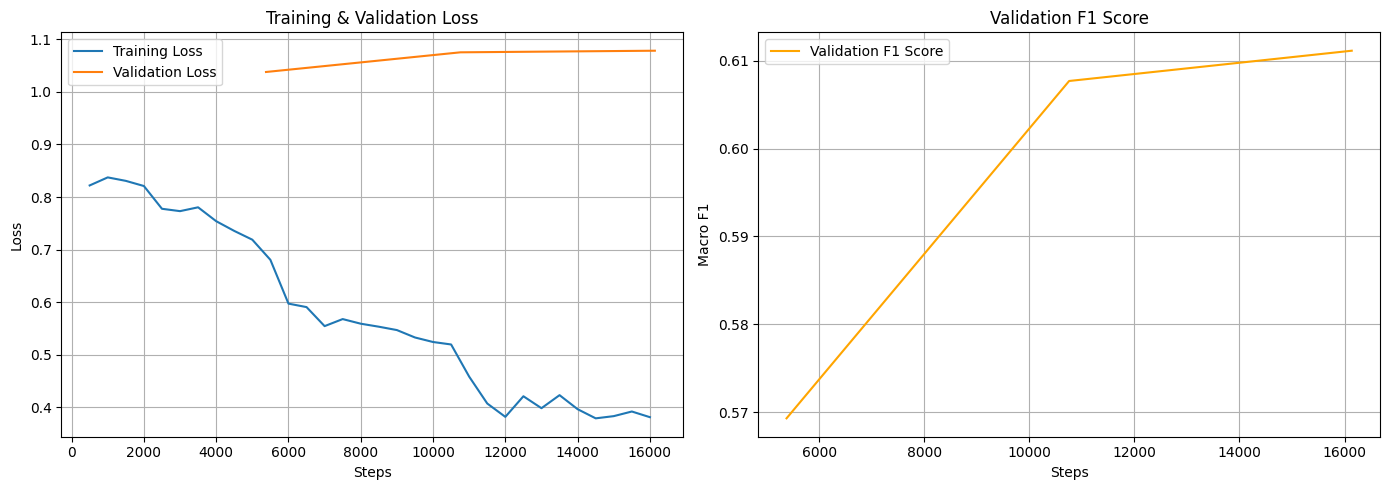


--- Evaluating on the Held-Out Test Set ---



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       944
           1       0.76      0.78      0.77       633
           2       0.67      0.70      0.68       482
           3       0.64      0.65      0.64       643
           4       0.66      0.68      0.67       569
           5       0.60      0.55      0.57      1642
           6       0.81      0.83      0.82       774
           7       0.77      0.81      0.79      3196
           8       0.84      0.80      0.82      1821
           9       0.65      0.70      0.68       287
          10       0.69      0.74      0.72       614
          11       0.70      0.63      0.66       299
          12       0.57      0.46      0.51        26
          13       0.67      0.18      0.29        22
          14       0.00      0.00      0.00         1

    accuracy                           0.74     11953
   macro avg       0.66      0.62      0.63     11953
we

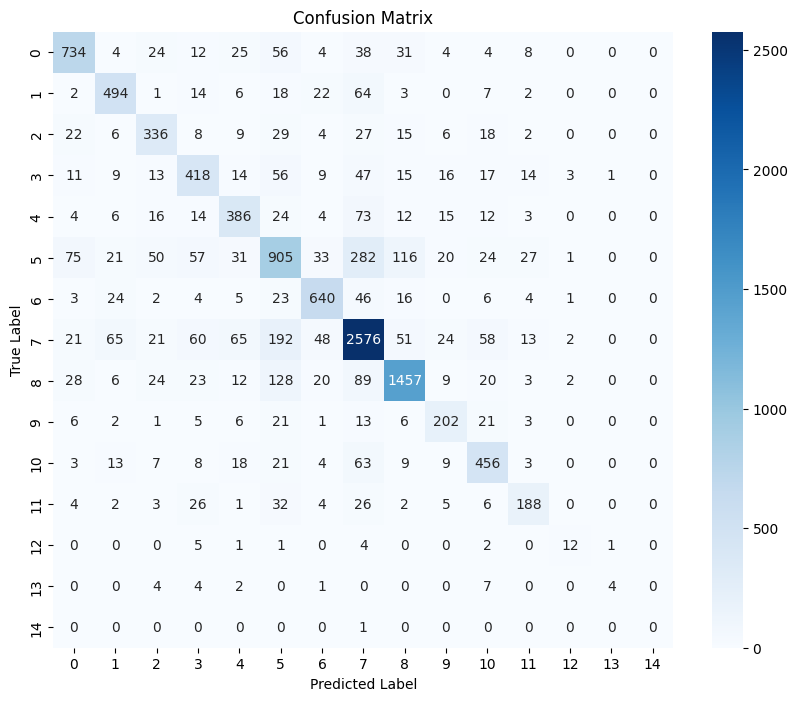

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_training_history(log_history):
    """
    Plots training and validation loss and F1 scores from the trainer's log history.
    """
    logs = pd.DataFrame(log_history)

    # Separate training and validation logs
    train_logs = logs[logs['loss'].notna()].copy()
    eval_logs = logs[logs['eval_loss'].notna()].copy()
    
    # Ensure 'step' is the index
    train_logs = train_logs.set_index('step')
    eval_logs = eval_logs.set_index('step')
    
    # Plotting Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_logs.index, train_logs['loss'], label='Training Loss')
    plt.plot(eval_logs.index, eval_logs['eval_loss'], label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plotting F1 Score
    plt.subplot(1, 2, 2)
    plt.plot(eval_logs.index, eval_logs['eval_f1'], label='Validation F1 Score', color='orange')
    plt.title('Validation F1 Score')
    plt.xlabel('Steps')
    plt.ylabel('Macro F1')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot Loss and F1 Curves
plot_training_history(trainer.state.log_history)


# Evaluate on your held-out test set (test_model_df)
print("\n--- Evaluating on the Held-Out Test Set ---")
results = trainer.predict(tokenized_ds["evaluation_test"])

# Get predictions and true labels
y_preds = np.argmax(results.predictions, axis=-1)
y_true = tokenized_ds["evaluation_test"]["label"]
labels_list = sorted(unique_labels)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_preds,
    labels=labels_list,
    target_names=[str(l) for l in labels_list],
    zero_division=0
))

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(
        y_true, 
        y_pred,
        labels=labels_list
    )
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\nGenerating Confusion Matrix...")
plot_confusion_matrix(y_true, y_preds, labels_list)

# Step 6: Prediction and Submission

In [39]:
print("\nGenerating predictions on the COMPETITION test set for submission...")

# Get predictions from the trained model
predictions = trainer.predict(tokenized_ds["competition_test"])
predicted_logits = predictions.predictions

# Get the class with the highest probability
predicted_ids = np.argmax(predicted_logits, axis=-1)

# Map the predicted integer IDs back to their original string labels
predicted_labels = [id2label[id] for id in predicted_ids]

# --- Create the submission file ---
print("Creating submission file...")
submission_df['label'] = predicted_labels
submission_df.to_csv("submission.csv", index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print("Top 5 rows of the submission file:")
print(submission_df.head())


Generating predictions on the COMPETITION test set for submission...


Creating submission file...

Submission file 'submission.csv' created successfully!
Top 5 rows of the submission file:
       id  label
0  114610      7
1    1146      2
2   39252      2
3   56935      7
4  113433      6


# Step 7: Load Model & Tokenizer

In [35]:
print("\nLoading model and tokenizer...")
model = AutoModelForSequenceClassification.from_pretrained(final_model_path)
tokenizer = AutoTokenizer.from_pretrained(final_model_path)
print("Model and tokenizer loaded successfully.")


Loading model and tokenizer...
Model and tokenizer loaded successfully.


In [41]:
!zip -r results.zip /kaggle/working/my_final_model

updating: kaggle/working/my_final_model/ (stored 0%)
updating: kaggle/working/my_final_model/special_tokens_map.json (deflated 85%)
updating: kaggle/working/my_final_model/tokenizer_config.json (deflated 75%)
updating: kaggle/working/my_final_model/sentencepiece.bpe.model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 49%)
updating: kaggle/working/my_final_model/config.json (deflated 59%)
updating: kaggle/working/my_final_model/model.safetensors (deflated 29%)
updating: kaggle/working/my_final_model/training_args.bin (deflated 51%)
updating: kaggle/working/my_final_model/tokenizer.json (deflated 76%)
